In [37]:
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt
from collections import deque
np.set_printoptions(precision=10)

class Arrivals:
    def __init__(self, n=100):
        self.n = n
        ls = [1 / (i + 1) for i in range(n)]
        sigma = sum(ls)
        ps = [1 / ((i + 1) * sigma) for i in range(n)]
        self.bin_size = 1 / n
        bins = [[ps[i], i] for i in range(n)]
        bins = bins[::-1]
        ind = 0
        while(bins[ind][0] < self.bin_size):
            ind += 1
        small_bins = bins[:ind]
        big_bins = bins[ind:]
        bins = []
        while(small_bins):
            bins.append([small_bins[0][0], small_bins[0][1], big_bins[0][1]])
            big_bins[0][0] -= self.bin_size - small_bins[0][0]
            if big_bins[0][0] < self.bin_size:
                small_bins.append(big_bins[0])
                big_bins = big_bins[1:]
            small_bins = small_bins[1:]
        bins.extend(big_bins)
        self.bins = bins
    def get_item(self):
        r = np.random.uniform(0, self.n)
        b = self.bins[int(r)]
        r = r - int(r)
        r *= self.bin_size
        if r > b[0]:
            return b[2]
        else:
            return b[1]

def fifo(cache, item, m):
    hit = item in cache
    if not hit:
        cache.popleft() # pop front (oldest) item
        cache.append(item) # add new item to the back
    return hit

def rand(cache, item, m):
    hit = item in cache
    if not hit:
        ind = random.randint(0, m - 1) # randomise item for eviction
        cache[ind] = item # replace the item
    return hit
        
def poisson(l):
    return -np.log(random.random()) / l
        
def run_simulation(m, n, policy, duration, batches, warmup):
    
    # some of these are initialised for performance boost
    # f.e. cache_range so that we don't need to recalculate
    # for every batch
    cache_range = range(m)
    cache = deque([i for i in cache_range])
    ls = [1 / i for i in range(1, n + 1)]
    arrivals = [0 for l in ls]
    end = duration + warmup
    out = []
    n_range = range(n)
    
    for i in range(batches):
        
        res = []
        # instead of creating a new arrays we can just reuse the ones
        # we calculated before. We can also reuse the 
        for j in n_range:
            arrivals[j] = poisson(ls[j])
        for j in cache_range:
            cache[j] = j
            
        hits = 0
        queries = 0
        curr = 0
        counter = 0
        while(curr < end):
            ind = np.argmin(arrivals) # get the index next arrival
            curr = arrivals[ind] # set the curr time to the next arrival
            hit = policy(cache, ind, m) # simulate cach query
            arrivals[ind] = poisson(ls[ind]) + curr # schedule the next arrival
            if hit:
                hits += 1
            queries += 1
            if (curr >= warmup):
                res.append(hits / queries)
        out.append(res)
    return out

def run_simulation_fast(m, n, policy, duration, batches, warmup):
    # same as run simulation but uses faster sampling from a discrete distribution
    cache_range = range(m)
    cache = deque([i for i in cache_range])
    arrivals = Arrivals(n)
    end = duration + warmup
    out = []
    n_range = range(n)
    
    for i in range(batches):
        
        res = []
        for j in cache_range:
            cache[j] = j
            
        hits = 0
        queries = 0
        curr = 0
        counter = 0
        while(curr < end):
            item = arrivals.get_item()
            curr += 1
            hit = policy(cache, item, m) # simulate cach query
            if hit:
                hits += 1
            queries += 1
            if (curr >= warmup):
                res.append(hits / queries)
        out.append(res)
    return out

def get_ci(x, alpha=0.025):
    """
    Calculates confidence interval
    
    Parameters:
    x [float]: data points
    alpha (float): the confidence measure
    """
    batches = len(x)
    x_bar = np.mean(x) # average
    s = np.std(x, ddof=1) / np.sqrt(batches) # sample variance
    if batches >= 40:
        t = stats.norm.ppf(1 - alpha) # if dataset is big enough use normal distribution
    else:
        t = stats.t.ppf(1 - alpha,df=batches - 1) # otherwise use T distribution
    d = t * s / np.sqrt(batches)
    return [x_bar - d, x_bar, x_bar + d]

def gather_results(m, n, policy, duration, batches, warmup):
    res = run_simulation(m, n, fifo, duration, batches, warmup)
    sig = sum([1 / (i + 1) for i in range(n)])
    for r in res:
        plt.plot(r)
    plt.show()
    x = [r[-1] for r in res]
    print("hit ratio: {}".format(get_ci(x)))
    print("miss rate: {}".format(get_ci([(1 - x_i) * sig for x_i in x])))
    print("point estimates: {}".format(x))
def to_tabular(arr):
    str_arr = [str(a)[:12] for a in arr]
    res = " & ".join(str_arr) + " \\\\"
    return res

def to_matrix(m):
    res = "$\\left[ \\begin{tabular}{ "
    for _ in m[0]:
        res += "c "
    res += "}\n"
    for row in m:
        str_row = [str(c)[:6] for c in row]
        res += "\t" + " & ".join(str_row) + " \\\\\n"
    res += "\\end{tabular} \\right]$"
    return res
    
def compare_policies(m, n, policy1, policy2, duration, batches, warmup):
    res1 = run_simulation_fast(m, n, policy1, duration, batches, warmup)
    res2 = run_simulation_fast(m, n, policy2, duration, batches, warmup)
    sig = sum([1 / (i + 1) for i in range(n)])

    x = [r[-1] for r in res1]
    y = [r[-1] for r in res2]
    comb = x + y
    # print to overleaf format
    print("Results for a simulation with m={}, n={}, duration={}, batches={}, and warmup={}:\n".format(m, n, duration, batches, warmup))
    print("\\begin{tabular}{|c|c|c|c|}")
    print("\t\\hline")
    print("\thit ratio {} & {}".format(policy1.__name__, to_tabular(get_ci(x))))
    print("\t\\hline")
    print("\thit ratio {} & {}".format(policy2.__name__, to_tabular(get_ci(y))))
    print("\t\\hline")
    print("\thit ratio combined & {}".format(to_tabular(get_ci(comb))))
    print("\t\\hline")
    print("\tmiss rate {} & {}".format(policy1.__name__, to_tabular(get_ci([(1 - x_i) * sig for x_i in x]))))
    print("\t\\hline")
    print("\tmiss rate {} & {}".format(policy2.__name__, to_tabular(get_ci([(1 - y_i) * sig for y_i in y]))))
    print("\t\\hline")
    print("\tmiss rate combined & {}".format(to_tabular(get_ci([(1 - x_i) * sig for x_i in comb]))))
    print("\t\\hline")
    print("\\end{tabular}\n\n")


In [41]:
compare_policies(10, 1000, fifo, rand, 1000000, 5, 2000)
compare_policies(50, 1000, fifo, rand, 1000000, 5, 2000)
compare_policies(100, 1000, fifo, rand, 1000000, 5, 2000)

Results for a simulation with m=10, n=1000, duration=1000000, batches=5, and warmup=2000:

\begin{tabular}{|c|c|c|c|}
	\hline
	hit ratio fifo & 0.1819559970 & 0.1822916167 & 0.1826272365 \\
	\hline
	hit ratio rand & 0.1818925110 & 0.1821243512 & 0.1823561915 \\
	\hline
	hit ratio combined & 0.1820954194 & 0.1822079840 & 0.1823205485 \\
	\hline
	miss rate fifo & 6.1184200033 & 6.1209322751 & 6.1234445469 \\
	\hline
	miss rate rand & 6.1204489028 & 6.1221843359 & 6.1239197690 \\
	\hline
	miss rate combined & 6.1207157069 & 6.1215583055 & 6.1224009040 \\
	\hline
\end{tabular}


Results for a simulation with m=50, n=1000, duration=1000000, batches=5, and warmup=2000:

\begin{tabular}{|c|c|c|c|}
	\hline
	hit ratio fifo & 0.4054561468 & 0.4055806387 & 0.4057051305 \\
	\hline
	hit ratio rand & 0.4052779134 & 0.4053534930 & 0.4054290725 \\
	\hline
	hit ratio combined & 0.4054191292 & 0.4054670658 & 0.4055150024 \\
	\hline
	miss rate fifo & 4.4485769276 & 4.4495088077 & 4.4504406878 \\
	\hline


In [42]:
m = 2
n = 3
ls = [1 / (i + 1) for i in range(n)] # lambdas
sig = sum(ls) # number of arrivals per second
ps = [0] + [1 / ((i + 1) * sig) for i in range(n)] # probability that i will arrive next is ps[i]

In [43]:
# Generate all possible states for rand policy with (1, 2) initial state.
# i.e. all pairs of the form (i, j) s.t. i != j and i, j <- {1, 2, 3}
S_rand = []
for i in range(1, n + 1):
    for j in range(i + 1, n + 1):
        S_rand.extend([(i, j), (j, i)])

# Generate the generator matrix
Q_rand = [[0 for _ in S_rand] for _ in S_rand]
for i, s1 in enumerate(S_rand):
    for j, s2 in enumerate(S_rand):
        # (i, j) -> (k, l) is possible only if i == k or j == l
        # but also one of the elements needs to change
        if s1[0] == s2[0] and s1[1] != s2[1]:
            Q_rand[i][j] = 1 / m * ps[s2[1]] # 1 / m is the probability of evicting a particular cell
                                             # and ps[s2[1]] is the probability of arrival of that item
        elif s1[0] != s2[0] and s1[1] == s2[1]:
            Q_rand[i][j] = 1 / m * ps[s2[0]]
for i, r in enumerate(Q_rand):
    Q_rand[i][i] = -sum(r)
print("Generator matrix: ")
print(to_matrix(Q_rand))
for i in Q_rand:
    i[-1] = 1
print("Augmented generator matrix: ")
print(to_matrix(Q_rand))

Generator matrix: 
$\left[ \begin{tabular}{ c c c c c c }
	-0.181 & 0 & 0.0909 & 0 & 0 & 0.0909 \\
	0 & -0.181 & 0 & 0.0909 & 0.0909 & 0 \\
	0.1363 & 0 & -0.272 & 0 & 0.1363 & 0 \\
	0 & 0.1363 & 0 & -0.272 & 0 & 0.1363 \\
	0 & 0.2727 & 0.2727 & 0 & -0.545 & 0 \\
	0.2727 & 0 & 0 & 0.2727 & 0 & -0.545 \\
\end{tabular} \right]$
Augmented generator matrix: 
$\left[ \begin{tabular}{ c c c c c c }
	-0.181 & 0 & 0.0909 & 0 & 0 & 1 \\
	0 & -0.181 & 0 & 0.0909 & 0.0909 & 1 \\
	0.1363 & 0 & -0.272 & 0 & 0.1363 & 1 \\
	0 & 0.1363 & 0 & -0.272 & 0 & 1 \\
	0 & 0.2727 & 0.2727 & 0 & -0.545 & 1 \\
	0.2727 & 0 & 0 & 0.2727 & 0 & 1 \\
\end{tabular} \right]$


[(1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2)]


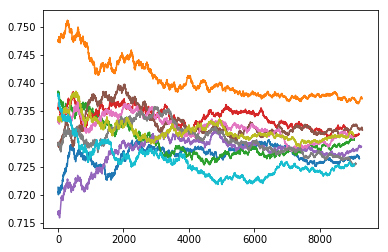

expected hit ratio: 0.7272727272727273
hit ratio: [0.7287946527363554, 0.7295858619233931, 0.7303770711104309]
miss rate: [0.49430870296421003, 0.495759253140446, 0.49720980331668196]
point estimates: [0.7264660493827161, 0.7371561410306083, 0.7297977811000078, 0.7307781649245064, 0.7286149519568784, 0.7315327793167128, 0.7300565326633166, 0.7254671983736023, 0.7306969459671104, 0.7252920745184718]


In [44]:
p_rand = [1 / 4, 1 / 4, 1 / 6, 1 / 6, 1 / 12, 1 / 12] #Solution to global equilibrium equations
hit_ratio_rand = 0
print(S_rand)
for i, s in enumerate(S_rand):
    hit_ratio_rand += (ps[s[0]] + ps[s[1]]) * p_rand[i]
res = run_simulation(2, 3, rand, 5000, 10, 2000)
for r in res:
    plt.plot(r)
plt.show()
print("expected hit ratio: {}".format(hit_ratio_rand))
x = [r[-1] for r in res]
print("hit ratio: {}".format(get_ci(x)))
print("miss rate: {}".format(get_ci([(1 - x_i) * sig for x_i in x])))
print("point estimates: {}".format(x))

In [45]:
S_fifo = [(1, 2), (2, 3), (3, 1)] # These are the only reachable states given (1, 2) is the initial one

# On the assumption that m = 2, and n = 3, generate the generator matrix
Q_fifo = [[0 for _ in S_fifo] for _ in S_fifo]
for i, s1 in enumerate(S_fifo):
    for j, s2 in enumerate(S_fifo):
        if s1[1] == s2[0]: # s2[1] is coming in to cache and s1[1] is evicted
            Q_fifo[i][j] = ps[s2[1]] # the probability of this state transition is precisely
                                     # the probability of hitting s2[1]
for i, r in enumerate(Q_fifo):
    Q_fifo[i][i] = -sum(r)
    
print("Generator matrix: ")
print(np.array(Q_fifo))
for i in Q_fifo:
    i[-1] = 1
print("Augmented generator matrix: ")
print(np.array(Q_fifo))

Generator matrix: 
[[-0.1818181818  0.1818181818  0.          ]
 [ 0.           -0.5454545455  0.5454545455]
 [ 0.2727272727  0.           -0.2727272727]]
Augmented generator matrix: 
[[-0.1818181818  0.1818181818  1.          ]
 [ 0.           -0.5454545455  1.          ]
 [ 0.2727272727  0.            1.          ]]


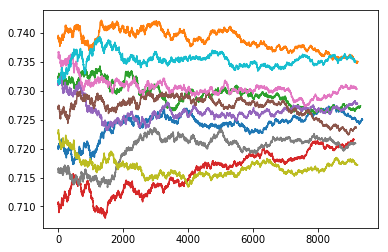

expected hit ratio: 0.7272727272727273
hit ratio: [0.7250339643515914, 0.7263800476441394, 0.7277261309366875]
miss rate: [0.4991687599494061, 0.5016365793190776, 0.504104398688749]
point estimates: [0.7249572915048921, 0.7350480322280756, 0.7273986304531815, 0.7215358148263997, 0.7277596646483465, 0.7235563845496231, 0.7303108202851133, 0.7209193245778611, 0.7171638899651298, 0.7351506234027724]


In [46]:
p_fifo = [1 / 2, 1 / 6, 1 / 3] # manually calculated
hit_ratio_fifo = 0
for i, s in enumerate(S_fifo):
    hit_ratio_fifo += (ps[s[0]] + ps[s[1]]) * p_fifo[i]
res = run_simulation(2, 3, fifo, 5000, 10, 2000)
for r in res:
    plt.plot(r)
plt.show()
print("expected hit ratio: {}".format(hit_ratio_fifo))
x = [r[-1] for r in res]
print("hit ratio: {}".format(get_ci(x)))
print("miss rate: {}".format(get_ci([(1 - x_i) * sig for x_i in x])))
print("point estimates: {}".format(x))